In [1]:
from line_follower import LineFollower
import cv2
import os
import yaml

In [8]:
%reload_ext autoreload
%autoreload 2

In [13]:
config_path = os.path.join(
    "..",
    "..",
    "..",
    "configs",
    "lab1",
    "line_follower_config.yaml",
)
with open(config_path, "r") as file:
    config = yaml.safe_load(file)

l = LineFollower(config)

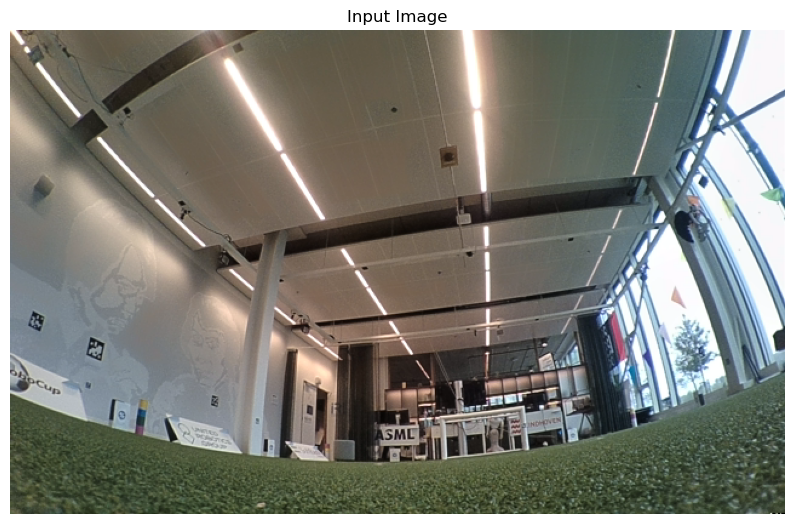

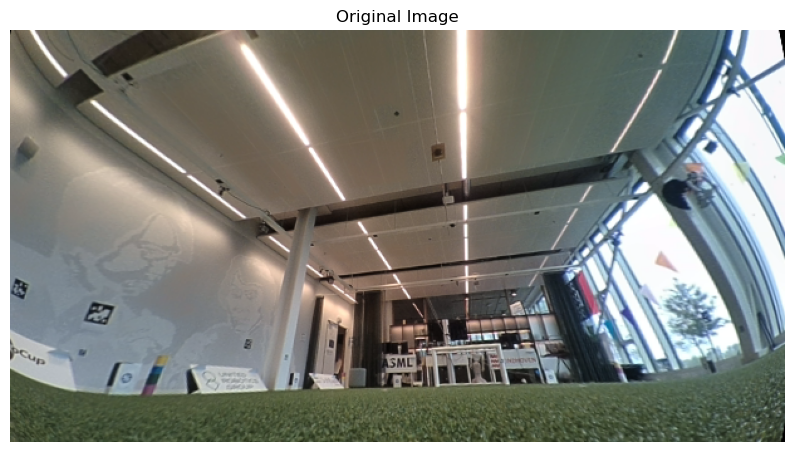

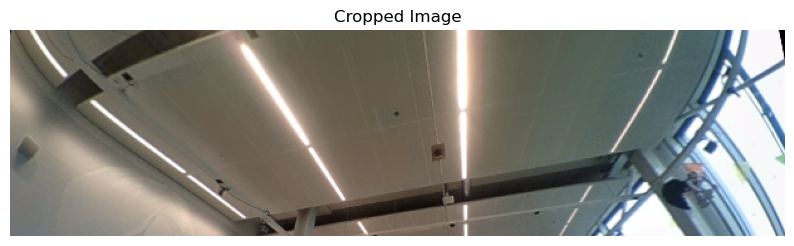

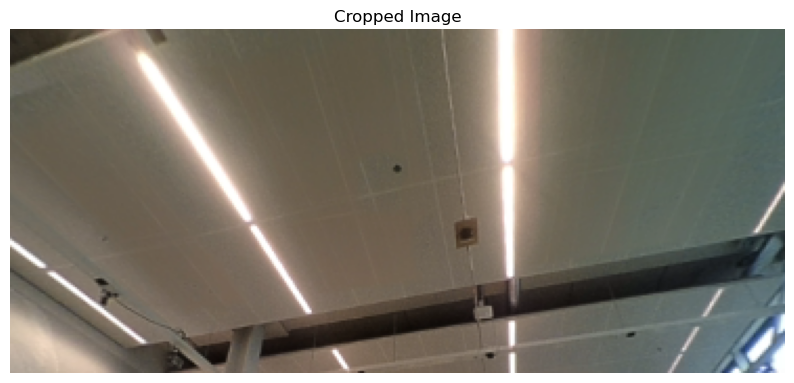

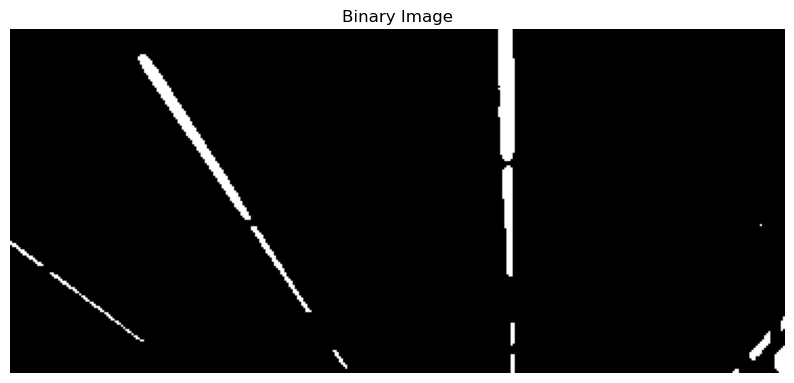

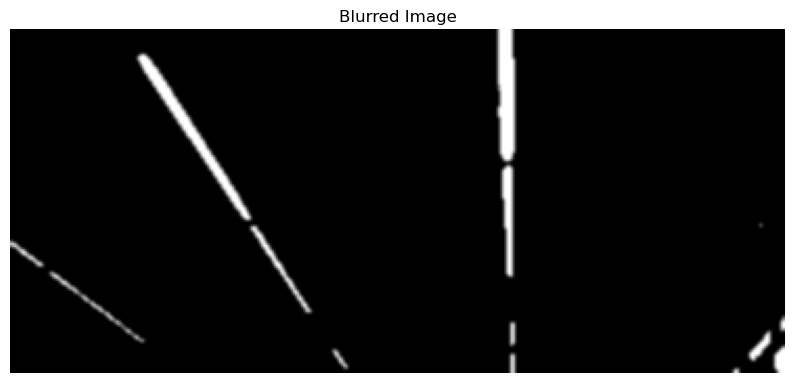

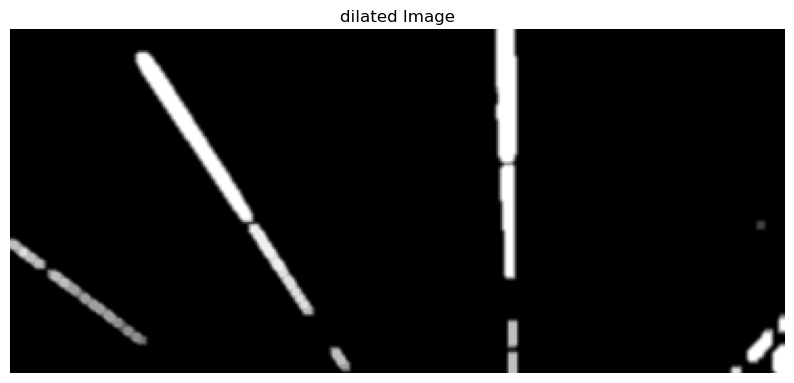

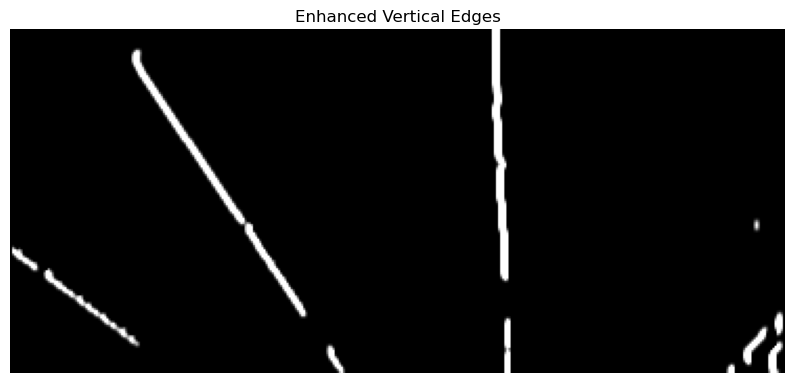

Discarding line with length 182.00274723201295 and angle 57.79439939076519
Found line with length 163.11039206623224 and angle 87.89190468764299
Discarding line with length 177.79201331893398 and angle 56.93560254326744
Discarding line with length 163.11039206623224 and angle 87.89190468764299
Discarding line with length 163.11039206623224 and angle 87.89190468764299
Discarding line with length 138.75518008348374 and angle 58.257238846581096
Discarding line with length 72.67048919609665 and angle 34.34609740006152
Discarding line with length 119.26860441876563 and angle 56.97613244420336
Discarding line with length 84.05950273467003 and angle 57.63336193527501
Found line with length 150.08331019803634 and angle 88.09084756700362
Discarding line with length 69.02897942168927 and angle 88.33971763101721
Discarding line with length 175.84083712266613 and angle 56.12918928961119
Discarding line with length 180.83417818543043 and angle 56.046303447135095


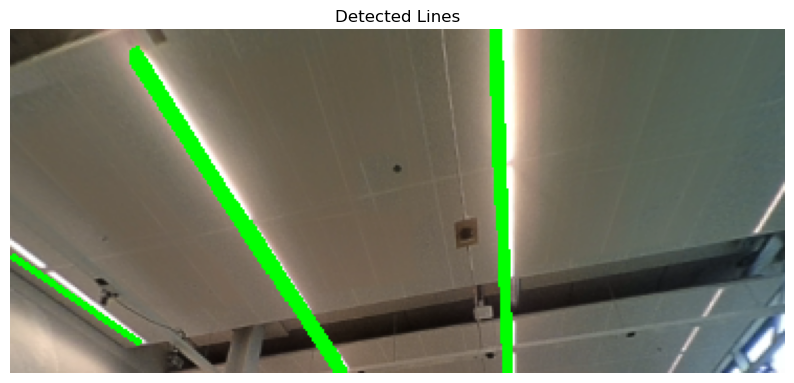

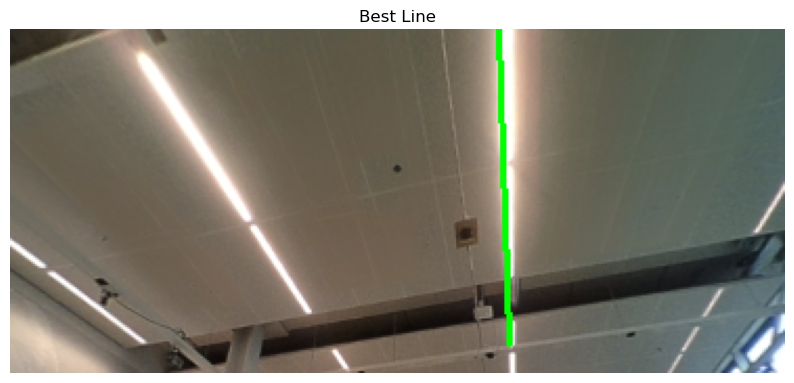

-0.10606402405535438
Turning right with: 0.10606402405535438 rad/s
Old action: (0.3, -0.3985735686934606) -> New action: (0.3, -0.10606402405535438)


(0.3, -0.10606402405535438)

In [ ]:
img = cv2.imread("../../../video/initial_image_54.png")  # normal video  12  30  40  old video 12 40 (41 for length)
# img = cv2.flip(img, 1)
l.pipeline(img)

In [3]:
%load_ext autoreload
%autoreload 2